
<a href="https://colab.research.google.com/github/kokchun/Machine-learning-AI22/blob/main/Exercises/E00_linear_regression.ipynb" target="_parent"><img align="left" src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a> &nbsp; to see hints and answers.

---
# Linear regression exercises

---
These are introductory exercises in Machine learning with focus in **linear regression** .

<p class = "alert alert-info" role="alert"><b>Note</b> all datasets used in this exercise can be found under Data folder of the course Github repo</p>

<p class = "alert alert-info" role="alert"><b>Note</b> that in cases when you start to repeat code, try not to. Create functions to reuse code instead. </p>

<p class = "alert alert-info" role="alert"><b>Remember</b> to use <b>descriptive variable, function, index </b> and <b> column names</b> in order to get readable code </p>

The number of stars (\*), (\*\*), (\*\*\*) denotes the difficulty level of the task

---

## 0. Simulate phone dataset (*)

We want to simulate data $(x,y)$ to represent cost for phone subscriptions, with: 

- $x$ - called minutes per month
- $y$ - SEK per month 

&nbsp; a) Use ```numpy.random.normal()``` to simulate a dataset with the following requirements:(*)
- set a seed to 42 (for reproducibility and reference)
- simulate 400 x-values from the r.v. $X \sim \mathcal{N}(100, 100)$ 
- take absolute value of these x-values
- simulate noise 400 noise values from r.v. $\epsilon \sim \mathcal{N(0, 50)}$ 
- Let $y = 2x+25+\epsilon$
- plot the data set 

&nbsp; b) Now we want to remove some outliers according to this assumption: (*)
- no one talks more than 300 min using this type of subscription
- no ones costs can be negative
- plot the new dataset
- also plot ground truth using the true parameters $\beta_0 = 25, \beta_1 = 2$

&nbsp; c) Insert the values into a DataFrame (*)

<details>

<summary>Answer</summary>

<img src="../assets/simulated_phone_dataset_0.png" height="200"/>

a) 

Number of points x ≥ 300 min: 8

Number of points y < 0 kr: 6


b)

Length of x, outliers removed 386

Length of y, outliers removed 386

c)

df.head()

|    |   Minutes |     Cost |
|---:|----------:|---------:|
|  0 |   59.4428 | 168.721  |
|  1 |   40.0625 |  98.2118 |
|  2 |  100.524  | 258.433  |
|  3 |  104.698  | 310.548  |
|  4 |   54.9935 | 123.279  |


</details>

---

In [989]:
# 0a) 

import numpy as np
np.random.seed(42)



# Notera att svaren i uppgifterna är blandade
num_samples = 400 
X_mean = 100
X_variance = 100
X = np.abs( np.random.normal(loc=X_mean, scale=X_variance, size=num_samples) )

e_mean = 0 
e_variance = 50
e = np.random.normal(loc=e_mean, scale=e_variance, size=num_samples)

y = X*2+25+e



In [990]:
# Not Needed
#import seaborn as sns
#sns.histplot(X, bins=20)

<Axes: title={'center': 'a) Simiulate 400 datapoints (incl. boundaries)'}, xlabel='Cost Minutes', ylabel='SEK/month'>

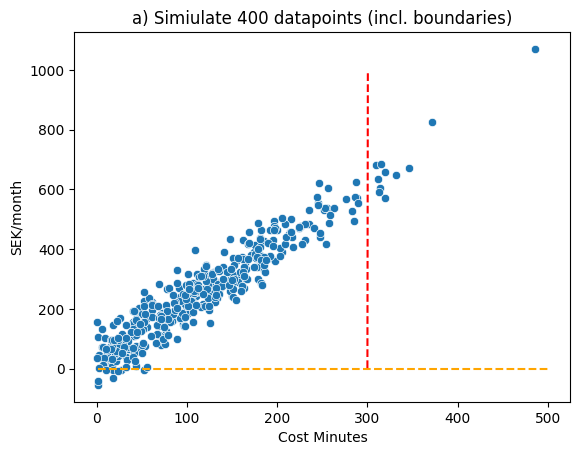

In [991]:

import seaborn as sns

sns.scatterplot(x=X, y=y).set(ylabel="SEK/month", xlabel="Cost Minutes", title=f"a) Simiulate 400 datapoints (incl. boundaries)" );
ls=np.linspace(1,500,500)
sns.lineplot(x=ls, y=0, linestyle='dashed', color="orange")
sns.lineplot(x=ls*.001+300, y=ls*2, linestyle='dashed', color="red")

In [992]:
# 0b)
# Remove to many spoken minutes
if np.any(X > 300):
    delete =  np.where(X > 300)
    X = np.delete(X, delete)
    y = np.delete(y, delete)
    print(f"x > 300 : {len(delete[0])}")

#Remove negative y
if np.any(y < 0):
    delete =  np.where(y < 0)
    X = np.delete(X, delete)
    y = np.delete(y, delete)
    print(f"y < 0 : {len(delete[0])}")

# M = np.column_stack([Y, X])
# filtered = M[(M[:,1]<=300) &(M[:,0]>0)]

print(X.shape[0])
print(y.shape[0])

x > 300 : 11
y < 0 : 8
381
381


<Axes: title={'center': 'b) Cleaned Outliers'}, xlabel='Cost Minutes', ylabel='SEK/month'>

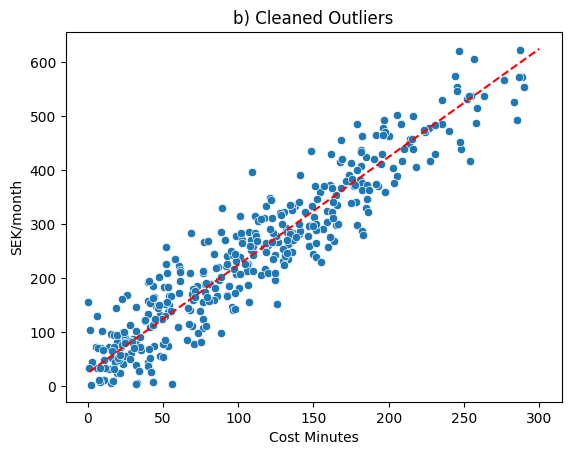

In [993]:
sns.scatterplot(x=X, y=y).set(ylabel="SEK/month", xlabel="Cost Minutes", title=f"b) Cleaned Outliers" );

# Ground truth = mu + e (the expected value of y + random error)
# ground turth $\beta_0 = 25, \beta_1 = 2$
gt = np.array([25, 2])
ls = np.linspace(1,300,300)
sns.lineplot(x=ls, y=gt[1]*ls+gt[0], linestyle='dashed', color="red")



In [994]:
# 0c)  Insert the values into a DataFrame
import pandas as pd 
df = pd.DataFrame({"called_minutes": X.round(), "SEK": y.round()})

## 1. Train|test split (*)

Before moving on with linear regression we shall first perform a train-test-split. 

&nbsp; a) Create a train-test-split function with the following call signature: (*)

```py
def train_test_split(X: pd.DataFrame, y: pd.DataFrame, train_fraction=.7: float, random_state=42: int, replace=False: bool) -> tuple
```

that returns the tuple:
```
(X_train, X_test, y_train, y_test)
```

&nbsp; b) Now use this to split up your data into a training set and test set. Check manually that the split is performed correctly. (*)


<details>

<summary>Hint</summary>

b) Check the length of each set, and check the indices of the sorted sets that they don't overlap and are not missing. Also check that they sum up to what you expect.

</details>

<br/>

<details>

<summary>Answer</summary>

Using default 0.7: 
- length of X_train: 270
- length of X_test: 116
- length of y_train: 270
- length of X_test: 116

</details>

---

In [995]:

# 1a)
# Replace = inplace (Hur funkarden när jag splittar upp datan?)
def train_test_split(X, y, train_fraction=.7, random_state=42, replace=False) -> tuple:
    np.random.seed(random_state)
    # If you stack and shuffle they maintain there relationship
    Xy = np.column_stack([X,y])
    np.random.shuffle(Xy)

    # Set the point where you want to split based on percentage
    split_point = int(train_fraction*len(Xy))
    # -1 to make sure the same value don't end up in both train and test
    Xy_train = Xy[:split_point]
    Xy_test =  Xy[split_point:]
    return Xy_train[:,:-1], Xy_test[:,:-1], Xy_train[:,-1], Xy_test[:,-1] 

# 1b)
X_train, X_test, y_train, y_test = train_test_split(X, y)
print( f"Are all values divided : {X.shape[0] == X_train.shape[0]+X_test.shape[0]}")
X_train.shape, X_test.shape, y_train.shape, y_test.shape

Are all values divided : True


((266, 1), (115, 1), (266,), (115,))

## 2. Simple linear regression with normal equation (*)

Use the normal equation for simple linear regression to solve for the coefficients $\hat{\beta} = (\beta_0, \beta_1)$. Note that you should only use the training data to fit the regression line, and not data from the test set. Plot the the regression line, together with ground truth and training data. 

<details>

<summary>Hint</summary>

It is important to keep track of the shapes of the vectors, matrices in order for matrix multiplication matmul "@" to work correctly. Also, if you have series object, you need to convert it to numpy. 

</details>

<br/>

<details>

<summary>Answer</summary>


<img src="../assets/Reg_line_normal_eq.png" height="200"/>

</details>

---

In [996]:
# 2)
ols = lambda X, y: np.linalg.pinv(X.T @ X) @ X.T @ y 
add_bias = lambda X: np.column_stack([np.ones(X.shape[0]), X])
X_train = add_bias(X_train)
b = ols(X_train, y_train)
b

def ols(X, y):
    return np.linalg.pinv(X.T @ X) @ X.T @ y 
#X_train.shape[0], y_train.shape[0]

array([32.22147722,  1.91050591])

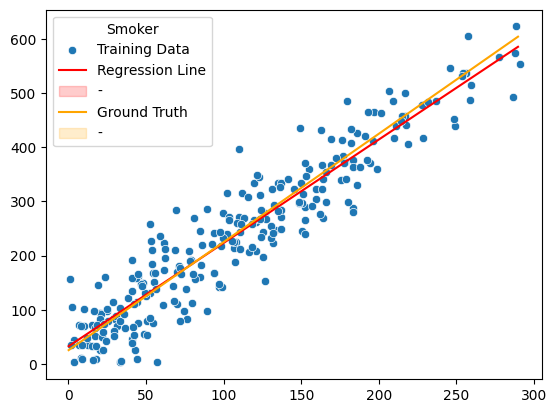

In [997]:
import seaborn as sns 
sns.scatterplot(x=X_train[:,0]+X_train[:,1], y=y_train)

g = np.array([25,2])

# Regression
seaborn_legend = sns.lineplot(x=X_train[:,1], y=X_train@b, color="red");
# Ground Truth
seaborn_legend = sns.lineplot(x=X_train[:,1], y=X_train@g, color="orange");
seaborn_legend.legend(title='Smoker', loc='upper left', labels=['Training Data', 'Regression Line', '-', 'Ground Truth', '-'])
#seaborn_legend = sns.pointplot(x="sex", y="total_bill", hue="day", data=plot)

b

## 3. Prediction and evaluation (*)

&nbsp; a) Use your model to make prediction on testing data. Plot the prediction cost against X_test, and y_test against X_test. (*)

&nbsp; b) Calculate MAE, MSE, RMSE (*)

<details>

<summary>Hint</summary>

Calculate y_pred from X_test and use y_test and y_pred to compute different evaluation metrics.

Careful with dimensions when computing the evaluation metrics, else it can be catastrophical logical errors due to numpy broadcasting feature.

Note that after you have calculate the error metrics on test data you are not allowed to change any parameters to make the line fit better to the testing data.

</details>

<br/>

<details>

<summary>Answer</summary>

a) 

<img src="../assets/eval_simple_lin_reg.png" height="200"/>

b)

Mean absolute error on testing data: 36.97 kr

Mean squared error on testing data: 2374 kr^2

Root mean squared error on testing data: 48.72 kr

</details>

---

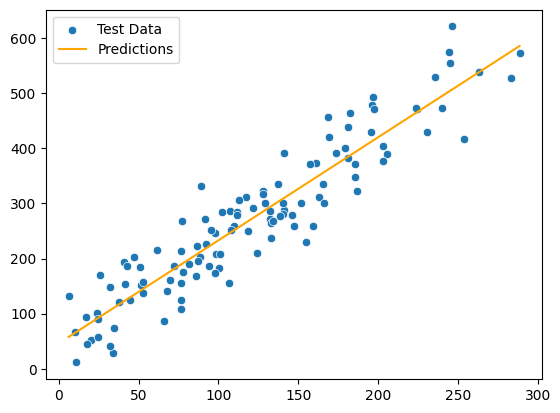

In [998]:
# y_pred against x_test : test är linjen
# y_test againast X_test : är scatter 

# 3a) 
X_test = add_bias(X_test)
b_train = ols(X_train, y_train)
b_test = ols(X_test, y_test)

plots = sns.scatterplot(x=X_test[:,1], y=y_test)
plots = sns.lineplot(x=X_test[:,1], y=X_test@b_test, color="orange")
plots.legend( labels=["Test Data", "Predictions"])


In [999]:
# 3b) 
n = len(y_test)
d = X_test.shape[1]-1
y_train_hat = X_train@b_train
y_test_hat = X_test@b_train

MAE = np.divide(1, n) * np.sum(np.abs(y_test - y_test_hat))
MSE = np.divide(1, n) * np.sum(np.square(y_test - y_test_hat))
RMSE = np.sqrt(MSE)
RSE = np.sqrt( np.divide(1, n-d) * np.sum(np.square(y_test - y_test_hat)) )

print(f"Samples: {n:<5} | MAE: {MAE:<7.2f} | MSE: {MSE:<7.2f} | RMSE: {RMSE:<7.2f}")

Samples: 115   | MAE: 40.12   | MSE: 2401.58 | RMSE: 49.01  


## 4. Simulate more explanatory variables (\*)

Now we will simulate the explanatory variables for minutes, text messages and amount of surf. For reference and reproducibility use numpy random seed 42. Assume there is:

- mean start cost: 25kr
- mean cost per minute: 2kr
- mean cost per sms: 50 öre
- mean cost per GB: 50kr

Then the model for the cost will be:
$y = 25 + 2x_1 + 0.5x_2 + 50x_3 + \epsilon$, where

- $x_i$ sampled from r.v. $X_i$ for $i = \{1,2,3\}$
- $X_1 \sim |\mathcal{N}(100,100)|$, (absolute value)
- $X_2 \sim \mathcal{U}(0,50)$, (discrete uniform distribution)
- $X_3 \sim |\mathcal{N}(0,2)|$,
- $\epsilon \sim \mathcal{N}(0,50)$

&nbsp; a) Simulate 10000 samples of each of $x_1, x_2, x_3$ and $y$ and save them in a DataFrame. Also add an intercept column containing ones. (\*)

&nbsp; b) Make histograms for each of the explanatory variables $x_1, x_2, x_3$ and the response variable $y$ (\*)

&nbsp; c) Clean the data using the following constraints (\*)

- surf should be less than 4
- minutes should be less than 300
- cost should be larger than 0

&nbsp; d) Make new histograms for the variables. (\*)

<details>

<summary>Hint</summary>
Your data analysis skill toolbox together with statistics and linear algebra skills are getting quite handy here.

</details>

<br/>

<details>

<summary>Answer</summary>

a)

|      | Intercept | Minutes | SMS | Surf (GB) |    Cost |
| ---: | --------: | ------: | --: | --------: | ------: |
|    0 |         1 | 149.671 |  41 |   2.26301 | 502.396 |
|    1 |         1 | 86.1736 |  16 | 0.0315695 | 179.072 |
|  ... |       ... |     ... | ... |       ... |     ... |
| 9318 |         1 | 149.577 |  31 |   3.43929 | 536.176 |
| 9319 |         1 | 164.439 |  43 |   1.40641 | 406.674 |

b)

<img src="../assets/hist_variables.png" height="200"/>

d)

<img src="../assets/hist_var_cleaned.png" height="200"/>

</details>

---


In [1000]:
# 4a)
import numpy as np

def generator(sam, seed, dis):
    np.random.seed(seed)
    def switch(beta, sam):
        if beta[0] == "bias":
            return np.ones(shape=sam)
        elif beta[0] == "normal":
            return np.random.normal(loc=beta[1], scale=beta[2], size=sam)
        elif beta[0] == "normal-abs":
            return np.abs(np.random.normal(loc=beta[1], scale=beta[2], size=sam))
        elif beta[0] == "uniform":
            # There is a 'uniform' but that produces decimal numbers aka continius
            return np.random.randint(low=beta[1], high=beta[2], size=sam )


    return np.column_stack( [switch(beta,sam) for beta in dis ])

X = generator(
    seed = 42, 
    sam = 1000, 
    dis = [
        ("bias",1),
        ("normal-abs",100,100),
        ("uniform",0,50),
        ("normal-abs",0,2),
        ("normal-abs",0,50),
    ])
y = X@np.array([25,2,0.5,50,1])

Xy = np.column_stack([X,y])
pd.DataFrame(X, columns=["Intercept", "Minutes", "SMS", "Surf", "Cost"] )

,Intercept,Minutes,SMS,Surf,Cost
0,1.0,149.671415,43.0,2.333097,35.381821
1,1.0,86.173570,48.0,1.145996,0.451909
2,1.0,164.768854,39.0,0.362233,53.243837
3,1.0,252.302986,10.0,1.671524,107.013294
4,1.0,76.584663,2.0,4.428503,70.033700
...,...,...,...,...,...
995,1.0,71.889971,38.0,0.933606,85.106720
996,1.0,279.768653,20.0,1.336141,29.871168
997,1.0,164.084286,9.0,2.011070,53.895087
998,1.0,42.882101,37.0,2.291076,27.702765


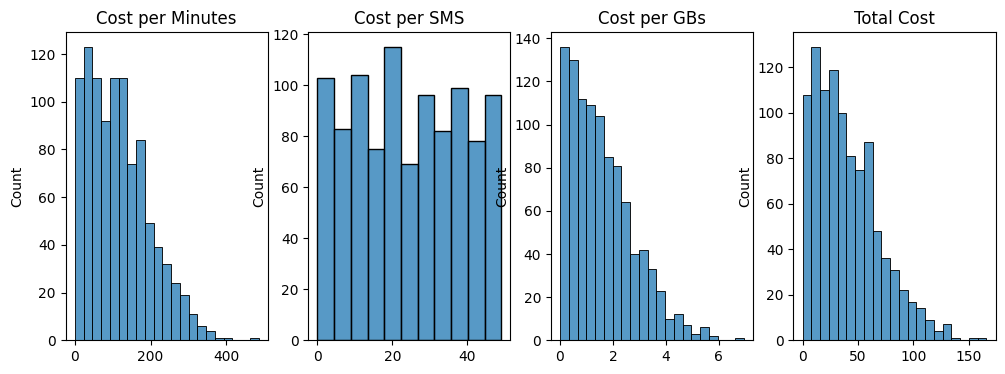

In [1001]:
# 4b)
import matplotlib.pyplot as plt 
Xy = np.column_stack([X,y])
n_features = Xy.shape[1] - 2
fig, ax = plt.subplots(1, n_features, figsize=(12,4), dpi=100) 

for idx in range(n_features):
    #sns.histplot(x=X[:,idx+1], y=y, ax=ax[idx]) 
    sns.histplot(x=Xy[:,idx+1], ax=ax[idx]) 
    #ax[idx].set(ylabel="total cost", xlabel="feature cost", title=f"cost for {["Minutes","SMS","GBs"][idx]}" )
    ax[idx].set(title=f"{["Cost per Minutes","Cost per SMS","Cost per GBs", "Total Cost"][idx]}" )

In [1002]:
# 5c)
def delete_outlisers(tar, X, y, ope, val):
    switch_where={
        ">": lambda tar, val: np.where(tar>val),
        "<": lambda tar, val: np.where(tar<val),
    }
    switch_any={
        ">": lambda tar, val: np.any(tar>val),
        "<": lambda tar, val: np.any(tar<val),
    }
    if switch_any[ope](tar,val):
        idx = switch_where[ope](tar,val)
        # Note that you need to set the axis to 0 if you want to delete a row in a multi dimensional arrays 
        return np.delete(X, idx, axis=0), np.delete(y, idx)
    return X, y 

X, y = delete_outlisers(y, X, y, "<", 0)
X, y = delete_outlisers(X[:,1], X, y, ">", 120)
X, y = delete_outlisers(X[:,3], X, y, ">", 3)

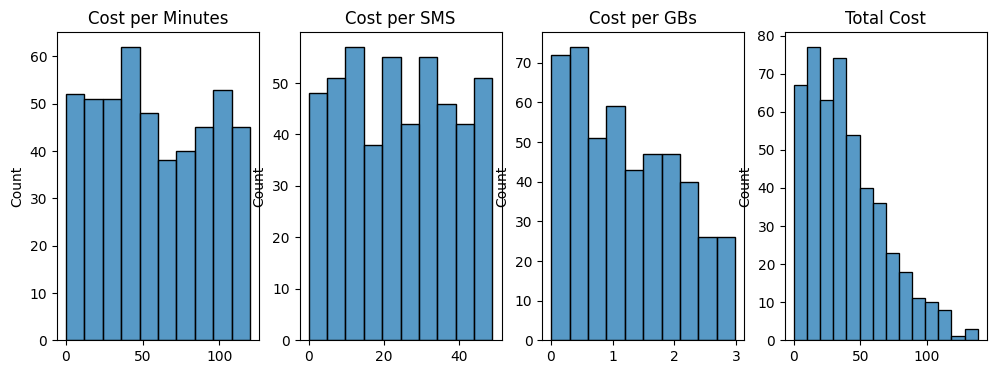

In [1003]:
# 5d)
import matplotlib.pyplot as plt 
Xy = np.column_stack([X,y])
n_features = Xy.shape[1] - 2
fig, ax = plt.subplots(1, n_features, figsize=(12,4), dpi=100) 

for idx in range(n_features):
    sns.histplot(x=Xy[:,idx+1], ax=ax[idx]) 
    ax[idx].set(title=f"{["Cost per Minutes","Cost per SMS","Cost per GBs", "Total Cost"][idx]}" )

## 5. Multiple linear regression (*)

&nbsp; a) Perform a train|test split with 0.8 of the data for training. (*)

&nbsp; b) Use the normal equation to compute $\hat{\beta}$ (*)

&nbsp; c) Predict on the test data and compute MAE, MSE and RMSE. (*)

&nbsp; d) Now repeat 4a), 4c), 5a), 5b) using 10, 100, 1000, 10000, 100000, 1000000 samples, and calculate RMSE for each of these simulations. Plot the RMSE against sample size. (**)


<details>

<summary>Hint</summary>

It is important to keep track of the shapes of the vectors, matrices in order for matrix multiplication matmul "@" to work correctly. Also, if you have series object, you need to convert it to numpy. 

</details>

<br/>

<details>
<summary>Answer</summary>


<img src="../assets/RMSE_simulation.png" height="200"/>

</details>

---

Kokchun Giang

[LinkedIn][linkedIn_kokchun]

[GitHub portfolio][github_portfolio]

[linkedIn_kokchun]: https://www.linkedin.com/in/kokchungiang/
[github_portfolio]: https://github.com/kokchun/Portfolio-Kokchun-Giang

---

In [1004]:
# 5a)
X_train, X_test, y_train, y_test = train_test_split(X, y, train_fraction=.8, random_state=42)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

# 5b)
b_train = ols(X_train, y_train)

n = len(y_test)
d = X_test.shape[1]-1
y_test_hat = X_test@b_train

# 5c)
MAE = np.divide(1, n) * np.sum(np.abs(y_test - y_test_hat))
MSE = np.divide(1, n) * np.sum(np.square(y_test - y_test_hat))
RMSE = np.sqrt(MSE)
RSE = np.sqrt( np.divide(1, n-d) * np.sum(np.square(y_test - y_test_hat)) )
print(f"MAE: {MAE:.2f} | MSE: {MSE:.2f} | RMSE: {RMSE:.2f}")
y_test[0], y_test_hat[0]

ols(X,y) 

(388, 5) (97, 5) (388,) (97,)
MAE: 0.00 | MSE: 0.00 | RMSE: 0.00


array([25. ,  2. ,  0.5, 50. ,  1. ])

In [1005]:
# 5d) 

# 1) Loop
for n in [10**n for n in range(1,7)]:
    
    # 2) Generate 
    X = generator(
        seed = 42, 
        sam = n, 
        dis = [
            ("bias",1),
            ("normal-abs",100,100),
            ("uniform",0,50),
            ("normal-abs",0,2),
            ("normal-abs",0,50),
        ])
    y = X@np.array([25,2,0.5,50,1])
    
    # 3) Split 
    X_train, X_test, y_train, y_test = train_test_split(X, y)
    
    # 4) Train 
    b_train = ols(X_train, y_train)
    # This should be +0 but it bugs out at 10 and 100 
    n = len(y_test)+2
    d = X_test.shape[1]-1
    y_test_hat = X_test@b_train

    # 5) Test 
    MAE = np.divide(1, n) * np.sum(np.abs(y_test, y_test_hat))
    MSE = np.divide(1, n) * np.sum(np.square(y_test, y_test_hat))
    RMSE = np.sqrt(MSE)
    RSE = np.sqrt( np.divide(1, n-d) * np.sum(np.square(y_test - y_test_hat)) )
    # Samples are 3/10 thats why they all start with a 3
    print(f"Samples: {n:<6} | MAE: {MAE:<7.2f} | MSE: {MSE:<7.2f} | RMSE: {RMSE:<7.2f}")
    #print(MAE, MSE, RMSE, RSE) 

Samples: 5      | MAE: 308.06  | MSE: 168696.89 | RMSE: 410.73 
Samples: 32     | MAE: 371.60  | MSE: 174880.63 | RMSE: 418.19 
Samples: 302    | MAE: 402.59  | MSE: 194519.41 | RMSE: 441.04 
Samples: 3002   | MAE: 389.18  | MSE: 181629.03 | RMSE: 426.18 
Samples: 30002  | MAE: 392.02  | MSE: 183837.06 | RMSE: 428.76 
Samples: 300002 | MAE: 390.23  | MSE: 182418.68 | RMSE: 427.10 
